### Study of the bursting dynamcis of the nodes

In [1]:
import sys
sys.path.insert(1, '/home/vinicius/GrayData-Analysis')
from   GDa.session           import session_info, session
from   GDa.spectral_analysis import filtering, time_frequency
from   GDa.misc.create_grids import create_stages_time_grid
from   GDa.graphics.plot_brain_sketch import plot_node_brain_sketch, plot_edge_brain_sketch
import numpy             as np
import matplotlib.pyplot as plt
import scipy
from   tqdm              import tqdm

#### Define stage and band names

In [2]:
stages      = ['baseline', 'cue', 'delay', 'match']
band_names  = [r'$\theta$', r'$\alpha$', r'$\beta$', r'low-$\gamma$ ', r'high-$\gamma$' ]

In [29]:
# Auxiliary function to smooth
def smooth(x, w=5):
    return scipy.signal.fftconvolve(x, np.ones(w)/w, mode='same')

# Compute z-score of time series
def z_score(x):
    return (x-x.mean())/x.std()

#### Phase locking value

In [4]:
def phase_locking_value(x, y):
    h1 = scipy.signal.hilbert(x)
    h2 = scipy.signal.hilbert(y)
    theta1 = np.unwrap(np.angle(h1))
    theta2 = np.unwrap(np.angle(h2))
    complex_phase_diff = np.exp(np.complex(0,1)*(theta1 - theta2))
    PLV = np.abs(np.sum(complex_phase_diff))/len(theta1)
    return PLV

#### Find activation sequences, their length, std and CV

In [5]:
def find_activation_sequences(spike_train):
    # make sure all runs of ones are well-bounded
    bounded = np.hstack(([0], spike_train, [0]))
    # get 1 at run starts and -1 at run ends
    difs    = np.diff(bounded)
    run_starts, = np.where(difs > 0)
    run_ends,   = np.where(difs < 0)
    act_lengths =  run_ends - run_starts  # Length of each activation sequence
    return act_lengths
    
def count_activations(spike_train):
    act_lengths = find_activation_sequences(spike_train)
    if len(spike_train)==0:
        mu, sigma   = 0,0
        cv          = 0
    else:
        mu, sigma   = act_lengths.mean(), act_lengths.std()
        cv          = sigma/mu
    return mu, sigma, cv

### Instantiating session object

In [6]:
# Instantiate class|
ses = session(raw_path = '../GrayLab/', monkey = 'lucy', date = '150128', session = 1,\
              slvr_msmod = False, align_to = 'cue', trial_type = 1, \
              behavioral_response = 1, evt_dt = [-0.65, 3.00])
# Read data from .mat files
ses.read_from_mat()

In [7]:
# Defining frequencies
delta = [4,8]
alpha = [8,16]
beta  = [16,40] 
low_gamma  = [40, 70]  
high_gamma = [70, 150]
bands      = [delta, alpha, beta, low_gamma, high_gamma]
freqs = np.arange(4,150,1)

# Morlet
W = time_frequency.wavelet_transform(data = ses.data, baseline_correction = False, 
                                     fs = ses.readinfo['fsample'], freqs = freqs, n_cycles = freqs/2,
                                     time_bandwidth = None, delta = 15, method = 'morlet', n_jobs = -1)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:  1.0min remaining:  1.5min
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:  1.2min remaining:   46.9s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:  1.4min remaining:   19.1s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:  1.6min finished


In [8]:
tarray = ses.readinfo['tarray'][::15][20:-20]
print(tarray.shape)

(204,)


In [9]:
W.shape

(540, 49, 146, 244)

In [10]:
### Power spectra
S = ( W[:,:,:,20:-20] * np.conj(W[:,:,:,20:-20]) ).real

In [11]:
S.shape

(540, 49, 146, 204)

In [12]:
S_avg = np.zeros([S.shape[0], S.shape[1], len(bands), S.shape[3]])
# Averaging over bands
for i in tqdm( range(len(bands)) ):
    band = bands[i]
    fidx = (freqs>=band[0])*(freqs<band[1])
    S_avg[:,:,i,:] = S[:,:,fidx,:].mean(axis=2)

100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


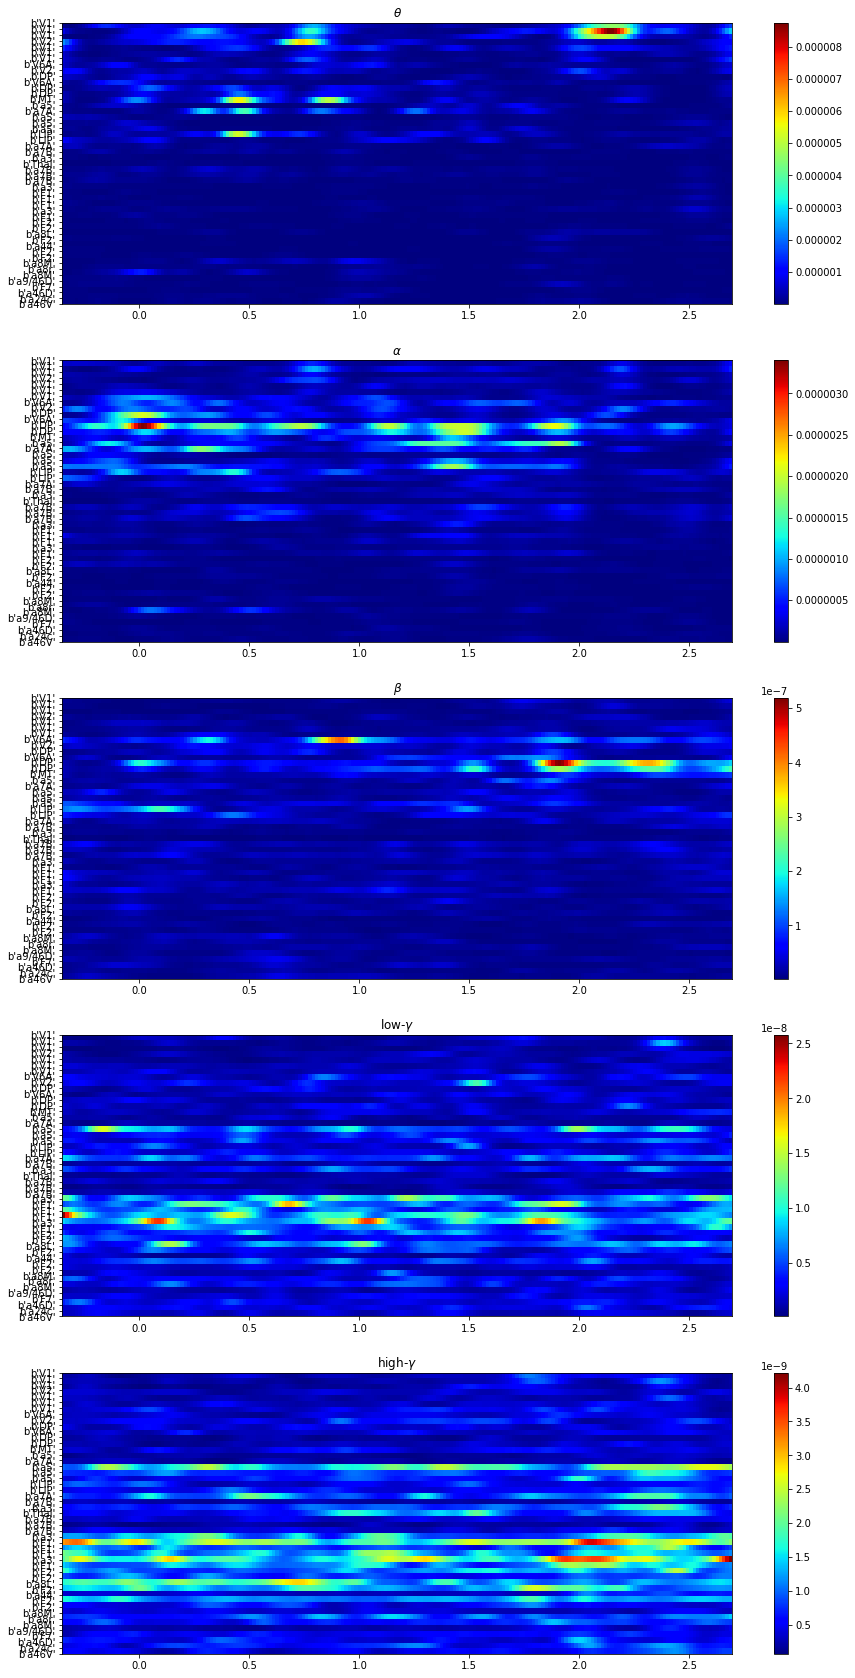

In [13]:
plt.figure(figsize=(15,30))
for i in range(len(bands)):
    plt.subplot(len(bands), 1, i+1)
    plt.imshow(S_avg[40,:,i,:],aspect='auto',cmap='jet',origin='lower', 
               extent=[tarray[0],tarray[-1],0,48])
    plt.title(band_names[i])
    plt.yticks(range(49), ses.readinfo['areas'])
    plt.colorbar()

#### Mask to track stages

In [14]:
t_mask = create_stages_time_grid(ses.readinfo['t_cue_on'], ses.readinfo['t_cue_off'], ses.readinfo['t_match_on'], 
                                 ses.readinfo['fsample'], tarray, ses.readinfo['nT'])

In [15]:
St = S_avg.swapaxes(0,2).reshape(ses.readinfo['nC'], len(bands), ses.readinfo['nT']*len(tarray))
print(St.shape)

(49, 5, 110160)


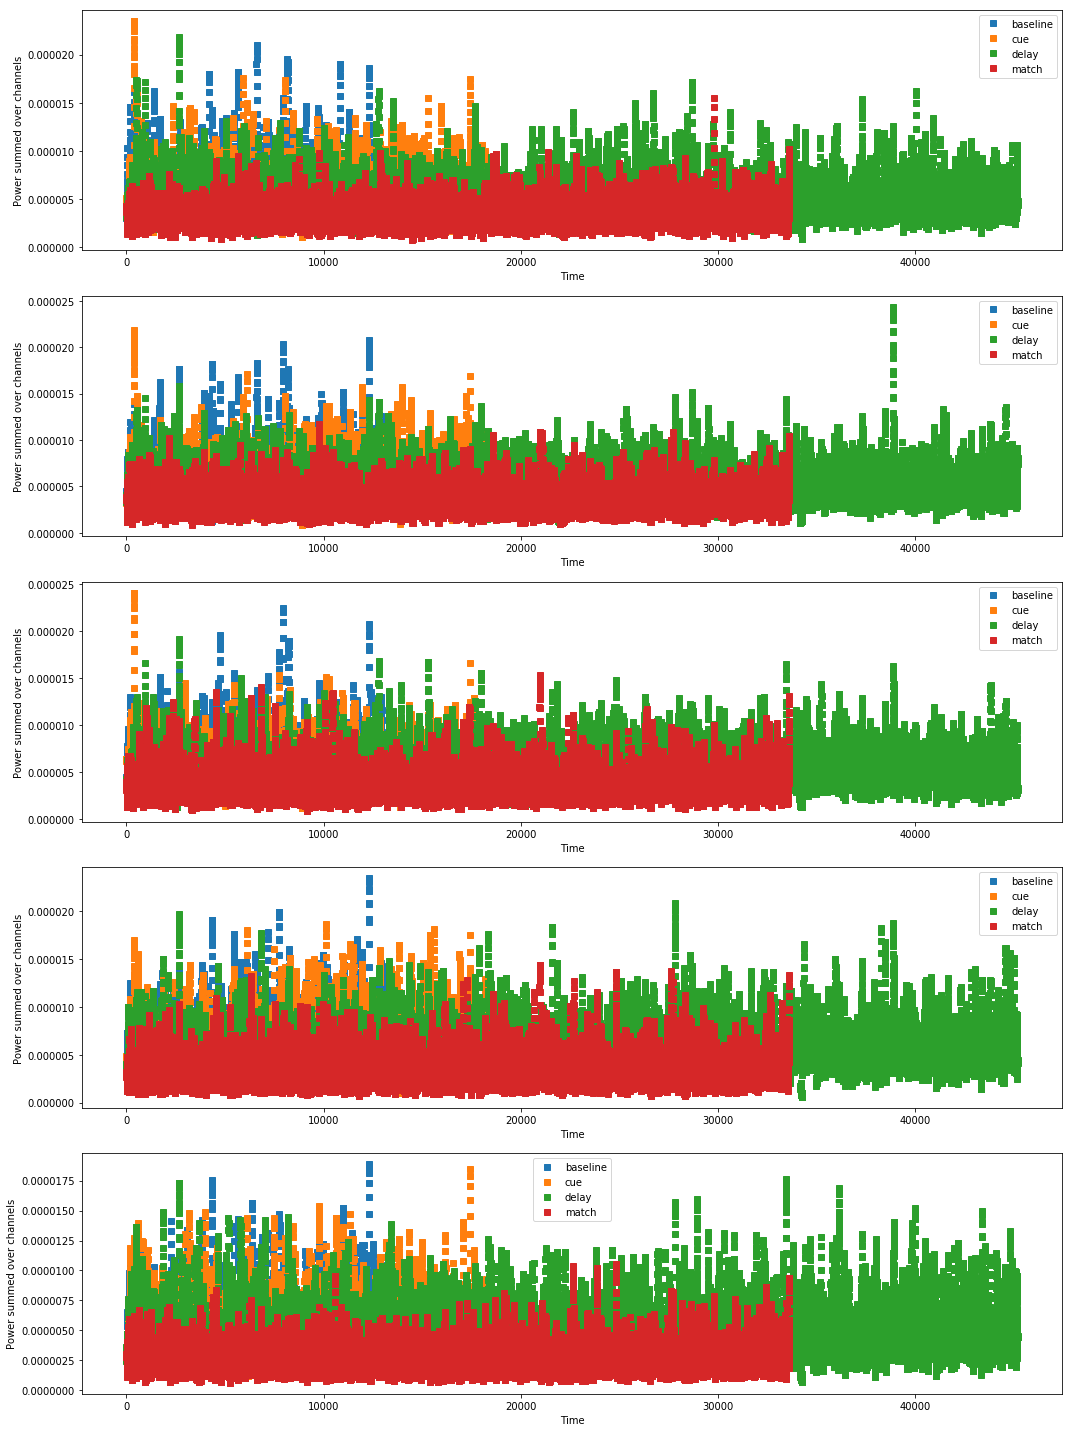

In [16]:
plt.figure(figsize=(15,20))
for i in range(len(bands)):
    plt.subplot(len(bands), 1, i+1)
    for s in range(len(stages)):
        plt.plot( St[:,i,t_mask[s]].sum(axis=0), 's', label = stages[s] )
    plt.ylabel('Power summed over channels')
    plt.xlabel('Time')
    plt.legend()
plt.tight_layout()

In [17]:
raster = np.zeros_like(S_avg)
for i in tqdm( range(len(bands)) ):
    for T in range(ses.readinfo['nT']):
        thr = scipy.stats.mstats.mquantiles(S_avg[T,:,i,:], prob=.95, axis=-1)
        raster[T,:,i,:]= S_avg[T,:,i,:]>thr

100%|██████████| 5/5 [00:14<00:00,  2.89s/it]


100%|██████████| 5/5 [00:00<00:00,  9.23it/s]


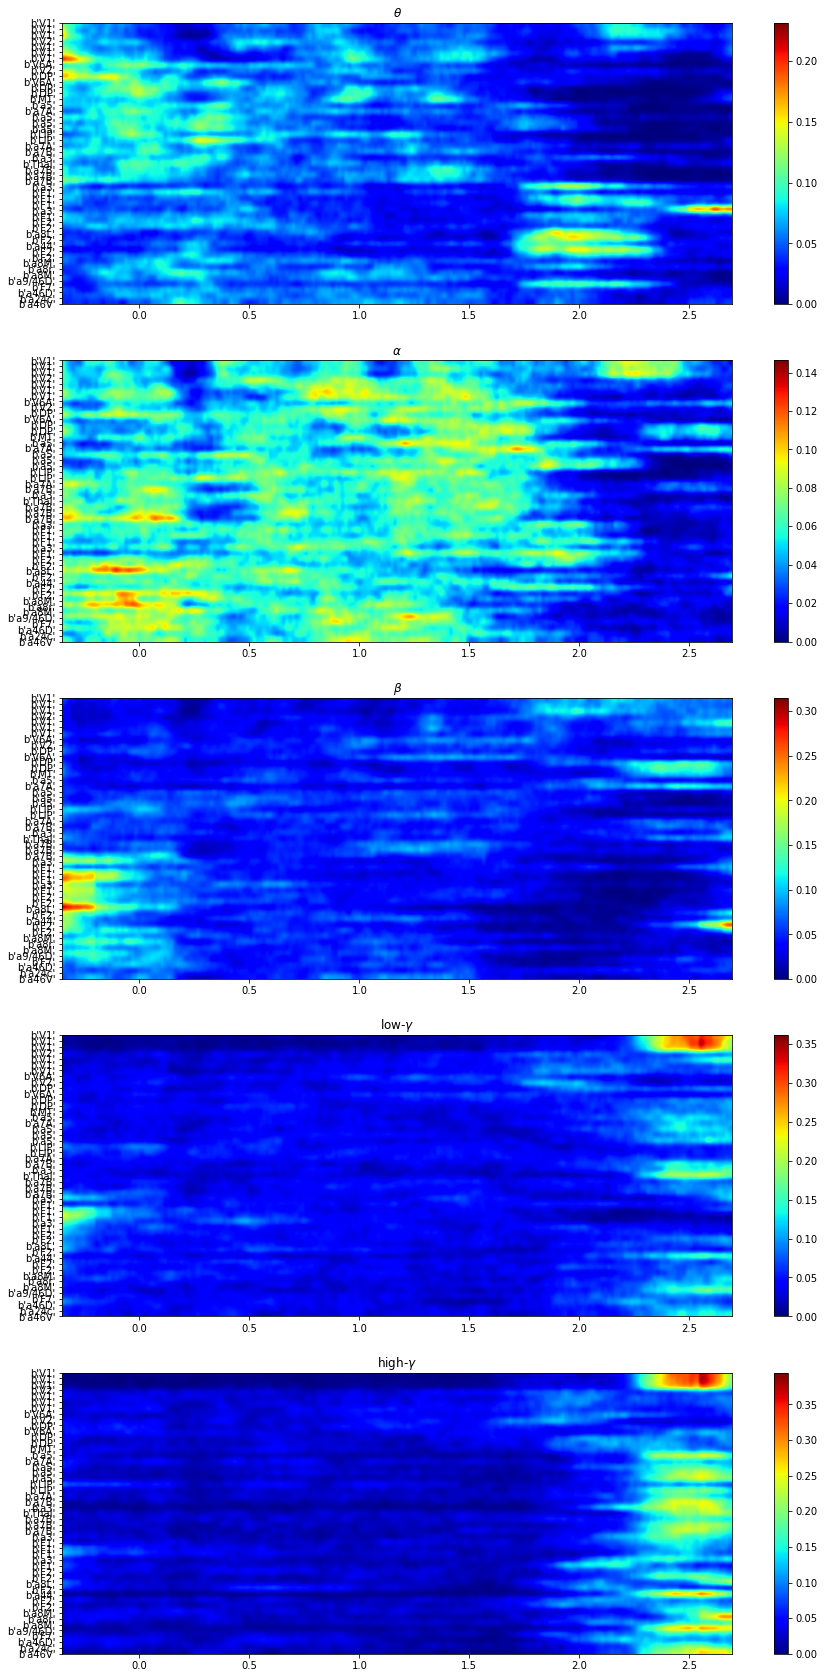

In [18]:
plt.figure(figsize=(15,30))
for i in tqdm( range(len(bands)) ):
    plt.subplot(len(bands), 1, i+1)
    plt.imshow(raster[:,:,i,:].mean(axis=0), aspect='auto',cmap='jet', origin='lower',
               extent=[tarray[0],tarray[-1],0,48], interpolation = 'gaussian')
    plt.colorbar()
    plt.yticks(range(49), ses.readinfo['areas'])
    plt.title(band_names[i])

### Distribution of power in each DRT stage

In [19]:
S_avg.shape

(540, 49, 5, 204)

In [20]:
S_ps = np.zeros([len(stages), S_avg.shape[0], S_avg.shape[1], len(bands)])
for i in tqdm( range(S_avg.shape[0]) ):
    for j in range(len(bands)):
        for s in range(len(stages)):
            idx  = t_mask[s].reshape(ses.readinfo['nT'], len(tarray))[i,:]
            S_ps[s,i,:,j] = S_avg[i,:,j,idx].mean(axis=0)

100%|██████████| 540/540 [00:00<00:00, 1299.07it/s]


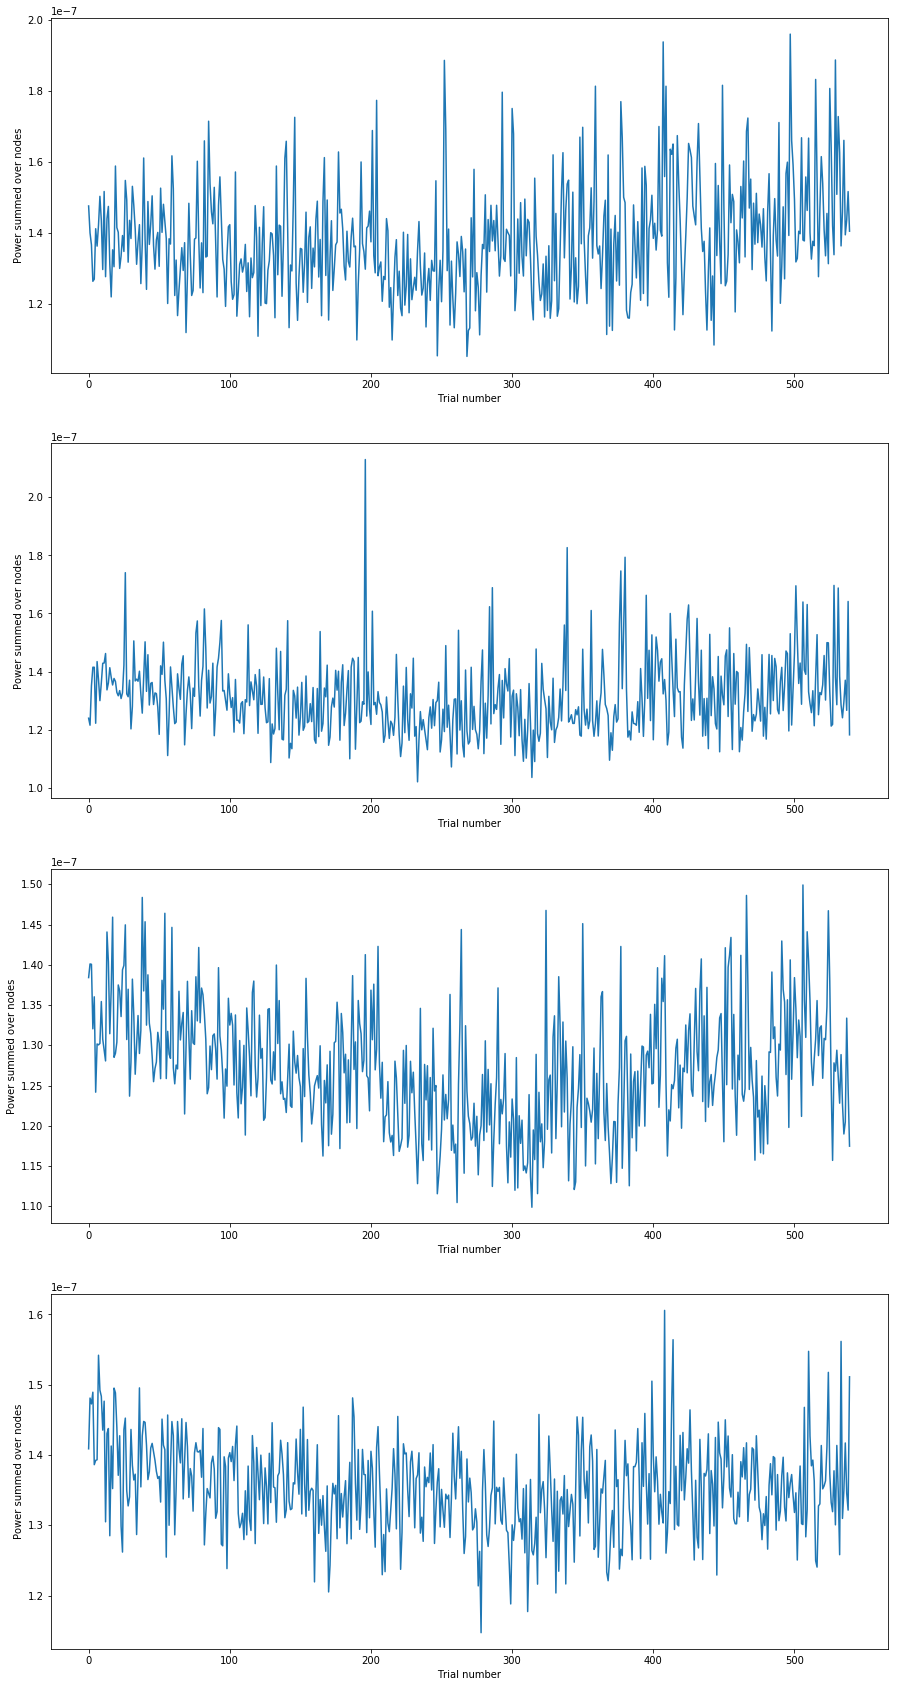

In [21]:
plt.figure(figsize=(15,30))
for i in range(len(stages)):
    plt.subplot(len(stages), 1, i+1)
    #plt.imshow(S_ps[i,:,:,0].T, aspect='auto', cmap='jet',origin='lower')
    plt.plot(S_ps[i,:,:,3].sum(axis=1))
    plt.xlabel('Trial number')
    plt.ylabel('Power summed over nodes')

### Distribution of power per task stage and band

In [22]:
P_mu  = np.zeros([ses.readinfo['nT'], len(stages), len(bands)])
P_std = np.zeros([ses.readinfo['nT'], len(stages), len(bands)])
for i in tqdm( range(S_avg.shape[0]) ):
    for j in range(len(bands)):
        for s in range(len(stages)):
            idx = t_mask[s].reshape(ses.readinfo['nT'], len(tarray))[i,:]
            P_mu[i,s,j]  = S_avg[i,:,j,idx].mean(axis=0).sum(axis=0)
            P_std[i,s,j] = S_avg[i,:,j,idx].std(axis=0).sum(axis=0)

100%|██████████| 540/540 [00:00<00:00, 543.24it/s]


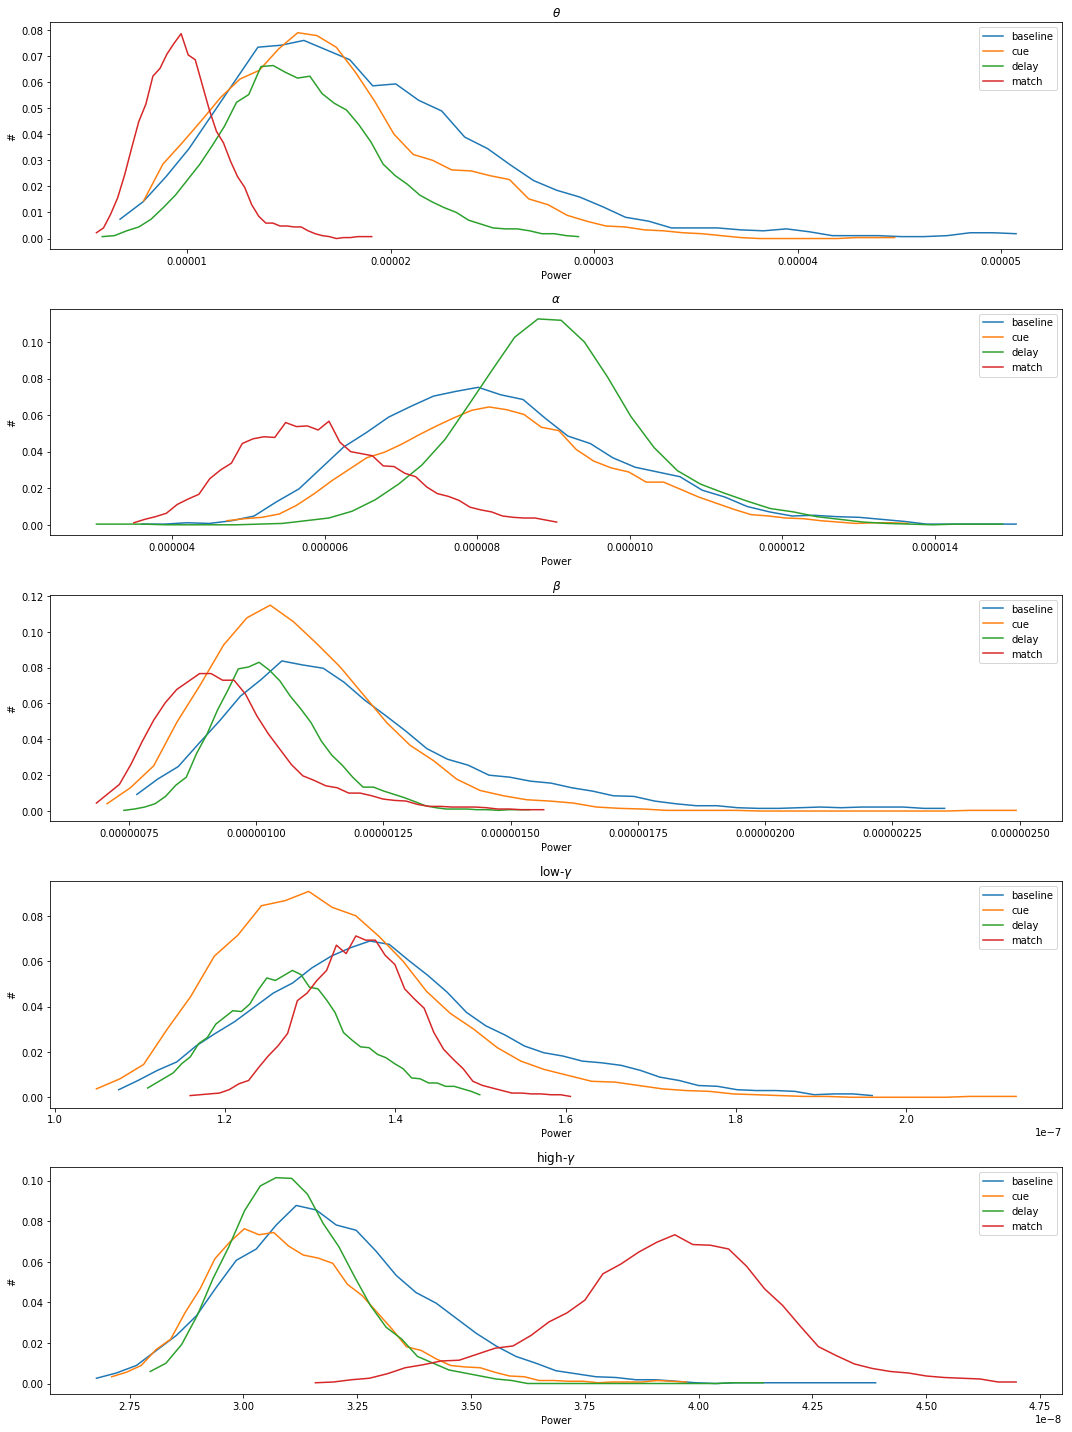

In [23]:
plt.figure(figsize=(15,20))
for j in range(len(bands)):
    plt.subplot(len(bands), 1, j+1)
    for i in range(len(stages)):
        n,x = np.histogram(P_mu[:,i,j], 40)
        n   = n/n.sum()
        plt.plot(x[1:], smooth(n, 5), label = stages[i])
    plt.legend()
    plt.title(band_names[j])
    plt.xlabel('Power')
    plt.ylabel('#')
plt.tight_layout()

In [24]:
mu = None
CV = np.zeros([raster.shape[0], raster.shape[1], len(bands), len(stages)])
for i in tqdm( range(S_avg.shape[0]) ):
    for j in range(len(bands)):
        for s in range(len(stages)):
            idx         = t_mask[s].reshape(ses.readinfo['nT'], len(tarray))[i,:]
            #CV[i,:,j,s] = np.apply_along_axis(count_activations, 0, raster[i,:,j,idx])[2,:]
            aux = np.apply_along_axis(smooth, 0, S_avg[i,:,j,idx])
            CV[i,:,j,s] = aux.std(axis=0 ) / aux.mean(axis=0)
            #aux = S_avg[i,:,j,idx]/S_avg[i,:,j,idx].sum(axis=0)
            #Hs  = np.sum( aux.T*np.log2(aux.T), axis=1 )/ np.log2(aux.shape[0])
            #CV[i,:,j,s] = Hs

100%|██████████| 540/540 [02:46<00:00,  3.25it/s]


### Nodes' burstiness over trials (as a function of band and stage)

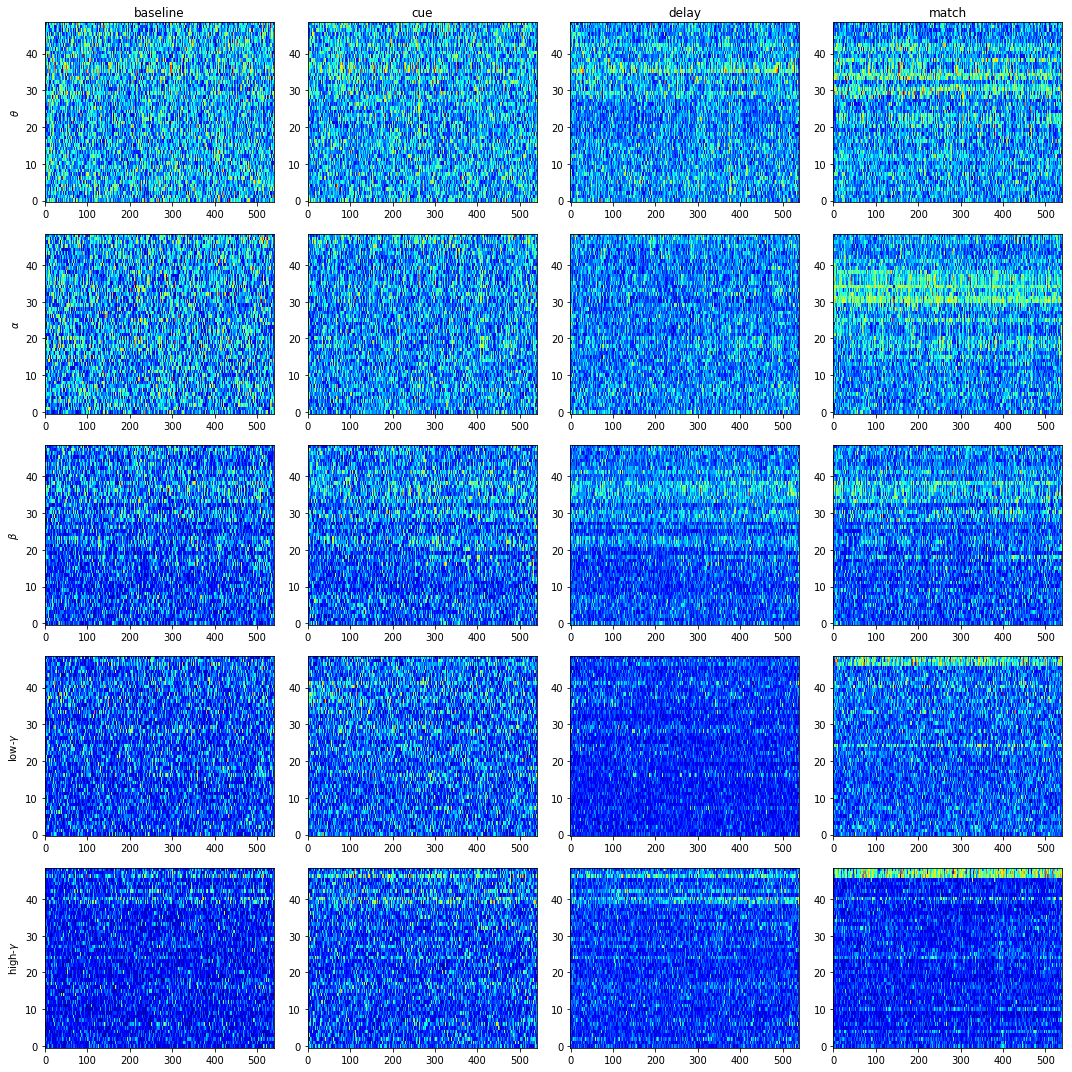

In [25]:
plt.figure(figsize = (15,15))
count = 1 
for j in range(len(bands)):
    for s in range(len(stages)):
        plt.subplot(len(bands), len(stages), count)
        plt.imshow(CV[:,:,j,s].T, aspect='auto', cmap='jet', origin='lower')
        count += 1
        if j == 0: plt.title(stages[s])
        if s == 0: plt.ylabel(band_names[j])
plt.tight_layout()

### Nodes' burstiness averaged over trials (as a function of band and stage)

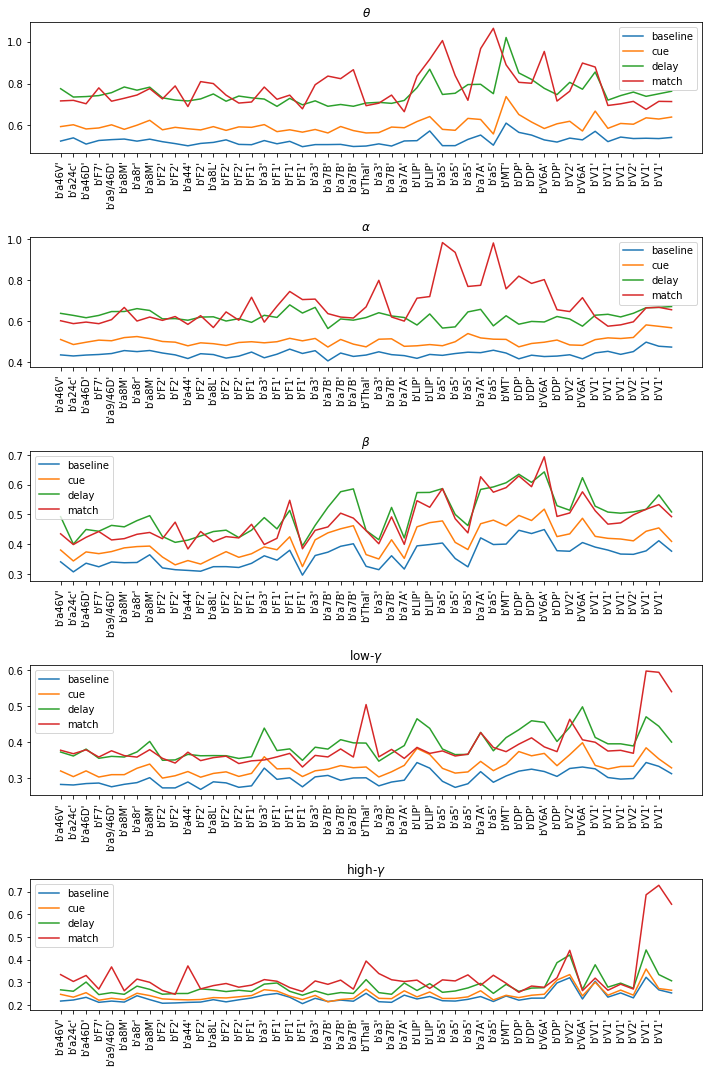

In [26]:
plt.figure(figsize = (10,15))
count = 1 
for j in range(len(bands)):
    plt.subplot(len(bands), 1, count)
    for s in range(len(stages)):
        plt.plot(np.nanmean( CV[:,:,j,s], axis=0), label = stages[s])
        plt.legend()
    plt.xticks(range(48), ses.readinfo['areas'], rotation = 90)
    plt.title(band_names[j])
    count += 1
plt.tight_layout()

### Summed nodes' burstiness over trials (as a function of band and stage)

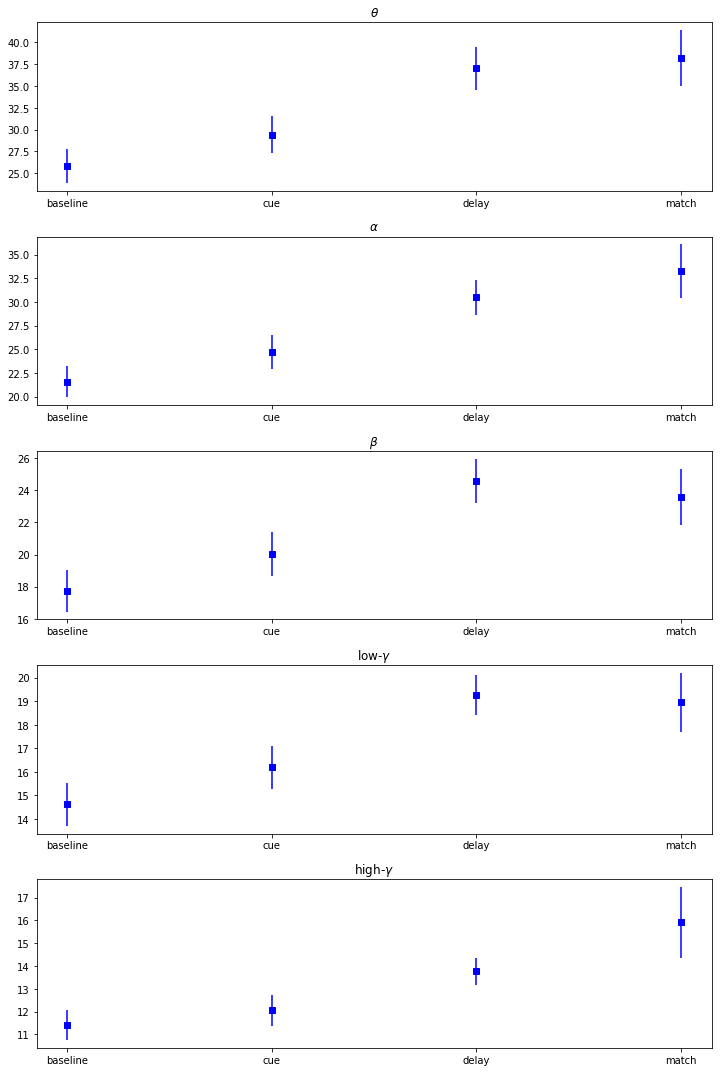

In [27]:
plt.figure(figsize = (10,15))
count = 1 
for j in range(len(bands)):
    plt.subplot(len(bands), 1, count)
    for s in range(len(stages)):
        plt.errorbar(s, np.nansum(CV[:,:,j,s], axis=1).mean(), 
                     np.nansum(CV[:,:,j,s], axis=1).std(), fmt='sb')
    plt.xticks(range(4), stages)
    plt.title(band_names[j])
    count += 1
plt.tight_layout()

### CV distributions per stage and bands

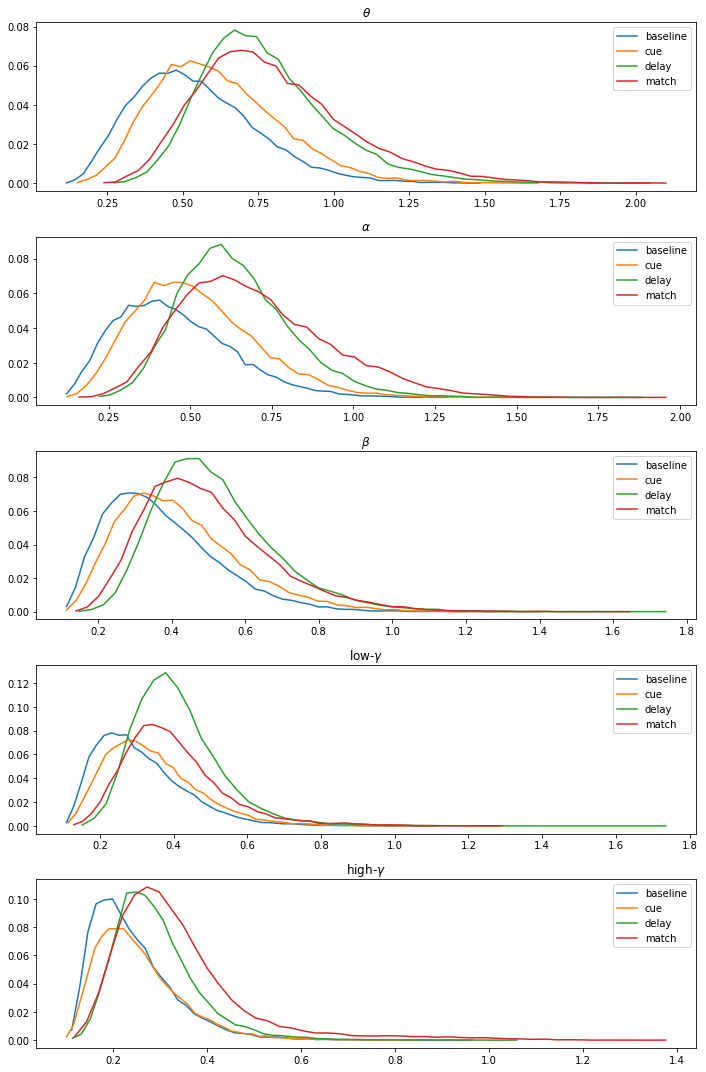

In [28]:
plt.figure(figsize = (10,15))
count = 1 
for j in range(len(bands)):
    plt.subplot(len(bands), 1, count)
    for s in range(len(stages)):
        n, x = np.histogram( CV[:,:,j,s].flatten(order='C'), 50 ) 
        n    = n / n.sum()
        plt.plot(x[1:], n, label = stages[s])
    plt.legend()
    plt.title(band_names[j])
    count += 1
plt.tight_layout()

In [137]:
S_avg.shape

(540, 49, 5, 204)

In [62]:
CC = np.zeros([raster.shape[0], ses.readinfo['pairs'].shape[0], len(bands), S_avg.shape[-1]])
for i in tqdm( range(S_avg.shape[0]) ):
    #for j in range(len(bands)):
    for p in range( ses.readinfo['pairs'].shape[0] ):
        #idx  = t_mask[s].reshape(ses.readinfo['nT'], len(tarray))[i,:]
        c1, c2 = ses.readinfo['pairs'][p,0], ses.readinfo['pairs'][p,1]
        x_i = z_score(S_avg[i,c1,3,:])
        x_j = z_score(S_avg[i,c2,3,:])
        CC[i,p,3,:] = x_i * x_j
        #np.corrcoef(S_avg[i,c1,j,idx], S_avg[i,c2,j,idx])[0,1]



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 1/540 [00:00<01:21,  6.63it/s]

  0%|          | 2/540 [00:00<01:20,  6.71it/s]

  1%|          | 3/540 [00:00<01:19,  6.75it/s]

  1%|          | 4/540 [00:00<01:19,  6.75it/s]

  1%|          | 5/540 [00:00<01:27,  6.09it/s]

  1%|          | 6/540 [00:00<01:28,  6.05it/s]

  1%|▏         | 7/540 [00:01<01:28,  5.99it/s]

  1%|▏         | 8/540 [00:01<01:28,  6.00it/s]

  2%|▏         | 9/540 [00:01<01:28,  5.98it/s]

  2%|▏         | 10/540 [00:01<01:24,  6.27it/s]

  2%|▏         | 11/540 [00:01<01:19,  6.65it/s]

  2%|▏         | 12/540 [00:01<01:16,  6.92it/s]

  2%|▏         | 13/540 [00:01<01:13,  7.15it/s]

  3%|▎         | 14/540 [00:02<01:13,  7.15it/s]

  3%|▎         | 15/540 [00:02<01:11,  7.31it/s]

  3%|▎         | 16/540 [00:02<01:10,  7.42it/s]

  3%|▎         | 17/540 [00:02<01:09,  7.51it/s]

  3%|▎         | 18/540 [00:02<01:08,  7.57it/s]

  4%|▎         | 19/540 [00:02<01:08,  7.62it/s]

  4%|▎         |

 27%|██▋       | 145/540 [00:19<00:53,  7.42it/s]

 27%|██▋       | 146/540 [00:19<00:52,  7.46it/s]

 27%|██▋       | 147/540 [00:19<00:52,  7.50it/s]

 27%|██▋       | 148/540 [00:20<00:52,  7.53it/s]

 28%|██▊       | 149/540 [00:20<00:51,  7.57it/s]

 28%|██▊       | 150/540 [00:20<00:51,  7.60it/s]

 28%|██▊       | 151/540 [00:20<00:51,  7.61it/s]

 28%|██▊       | 152/540 [00:20<00:51,  7.61it/s]

 28%|██▊       | 153/540 [00:20<00:50,  7.60it/s]

 29%|██▊       | 154/540 [00:20<00:50,  7.62it/s]

 29%|██▊       | 155/540 [00:20<00:50,  7.61it/s]

 29%|██▉       | 156/540 [00:21<00:50,  7.64it/s]

 29%|██▉       | 157/540 [00:21<00:50,  7.64it/s]

 29%|██▉       | 158/540 [00:21<00:49,  7.65it/s]

 29%|██▉       | 159/540 [00:21<00:49,  7.69it/s]

 30%|██▉       | 160/540 [00:21<00:49,  7.68it/s]

 30%|██▉       | 161/540 [00:21<00:49,  7.70it/s]

 30%|███       | 162/540 [00:21<00:49,  7.66it/s]

 30%|███       | 163/540 [00:21<00:49,  7.65it/s]

 30%|███       | 164/540 [00:22

 53%|█████▎    | 288/540 [00:38<00:33,  7.45it/s]

 54%|█████▎    | 289/540 [00:38<00:33,  7.45it/s]

 54%|█████▎    | 290/540 [00:38<00:33,  7.46it/s]

 54%|█████▍    | 291/540 [00:38<00:33,  7.37it/s]

 54%|█████▍    | 292/540 [00:39<00:33,  7.41it/s]

 54%|█████▍    | 293/540 [00:39<00:33,  7.38it/s]

 54%|█████▍    | 294/540 [00:39<00:33,  7.41it/s]

 55%|█████▍    | 295/540 [00:39<00:33,  7.42it/s]

 55%|█████▍    | 296/540 [00:39<00:33,  7.34it/s]

 55%|█████▌    | 297/540 [00:39<00:33,  7.31it/s]

 55%|█████▌    | 298/540 [00:39<00:33,  7.33it/s]

 55%|█████▌    | 299/540 [00:40<00:32,  7.33it/s]

 56%|█████▌    | 300/540 [00:40<00:32,  7.32it/s]

 56%|█████▌    | 301/540 [00:40<00:33,  7.24it/s]

 56%|█████▌    | 302/540 [00:40<00:32,  7.30it/s]

 56%|█████▌    | 303/540 [00:40<00:32,  7.33it/s]

 56%|█████▋    | 304/540 [00:40<00:32,  7.37it/s]

 56%|█████▋    | 305/540 [00:40<00:31,  7.40it/s]

 57%|█████▋    | 306/540 [00:41<00:31,  7.43it/s]

 57%|█████▋    | 307/540 [00:41

 80%|███████▉  | 431/540 [00:55<00:11,  9.19it/s]

 80%|████████  | 432/540 [00:55<00:11,  9.19it/s]

 80%|████████  | 433/540 [00:55<00:11,  9.24it/s]

 80%|████████  | 434/540 [00:55<00:11,  9.05it/s]

 81%|████████  | 435/540 [00:55<00:11,  9.13it/s]

 81%|████████  | 436/540 [00:55<00:11,  9.18it/s]

 81%|████████  | 437/540 [00:55<00:11,  9.19it/s]

 81%|████████  | 438/540 [00:55<00:11,  9.21it/s]

 81%|████████▏ | 439/540 [00:56<00:10,  9.24it/s]

 81%|████████▏ | 440/540 [00:56<00:10,  9.15it/s]

 82%|████████▏ | 441/540 [00:56<00:10,  9.16it/s]

 82%|████████▏ | 442/540 [00:56<00:10,  9.21it/s]

 82%|████████▏ | 443/540 [00:56<00:10,  9.22it/s]

 82%|████████▏ | 444/540 [00:56<00:10,  9.26it/s]

 82%|████████▏ | 445/540 [00:56<00:10,  9.27it/s]

 83%|████████▎ | 446/540 [00:56<00:10,  9.11it/s]

 83%|████████▎ | 447/540 [00:56<00:10,  9.18it/s]

 83%|████████▎ | 448/540 [00:57<00:10,  9.18it/s]

 83%|████████▎ | 449/540 [00:57<00:09,  9.22it/s]

 83%|████████▎ | 450/540 [00:57

In [63]:
CC.shape

(540, 1176, 5, 204)

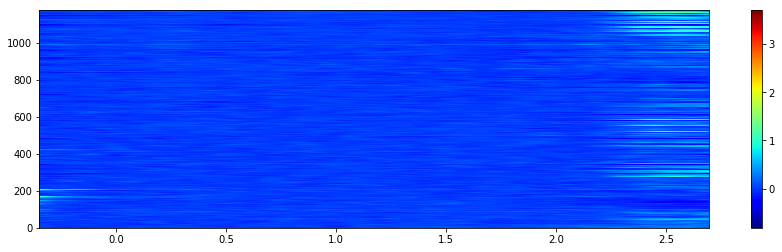

In [65]:
plt.figure(figsize=(15,4))
plt.imshow(CC[:,:,3,:].mean(axis=0), aspect='auto', cmap='jet', origin='lower', extent=[tarray[0],tarray[-1],0,1175])
plt.colorbar()

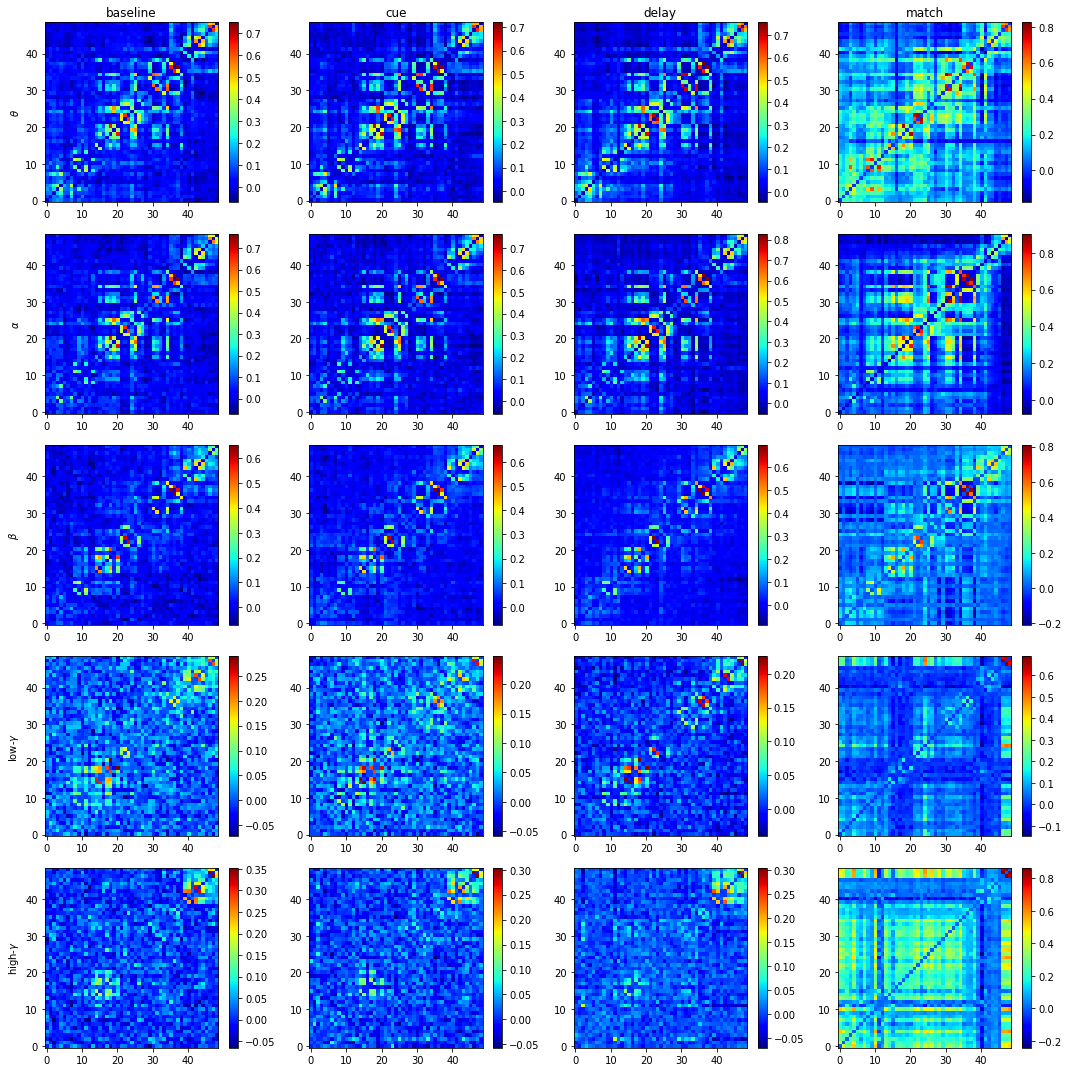

In [147]:
plt.figure(figsize=(15,15))
count = 1
for j in range(len(bands)):
    for s in range(len(stages)):
        plt.subplot(len(bands), len(stages), count)
        aux = CC[:,:,:,j,s].mean(axis=0) + CC[:,:,:,j,s].mean(axis=0).T
        plt.imshow(aux , aspect='auto', cmap='jet', origin='lower')
        plt.colorbar()
        if j == 0: plt.title(stages[s])
        if s == 0: plt.ylabel(band_names[j])
        count+=1
plt.tight_layout()

In [27]:
data = ( ses.data - ses.data.mean(axis=-1)[:,:,None] ) / ses.data.std(axis=-1)[:,:,None]

In [119]:
data = filtering.bp_filter(data = ses.data, fs = ses.readinfo['fsample'], f_low = 4, f_high = 8, n_jobs = -1)

In [120]:
data = ( data - data.mean(axis=-1)[:,:,None] ) / data.std(axis=-1)[:,:,None]

In [132]:
delta = 15
nFC = np.zeros([ses.data.shape[0], ses.data.shape[1], ses.data.shape[1], int(np.ceil(ses.data.shape[-1]/delta)) ])
for i in tqdm( range(ses.data.shape[0]) ):
    for n1, n2 in ses.readinfo['pairs']:
        nFC[i,n1,n2,:] = nFC[i,n2,n1,:] = data[i,n1,::delta] * data[i,n2,::delta]

100%|██████████| 540/540 [00:06<00:00, 88.33it/s] 


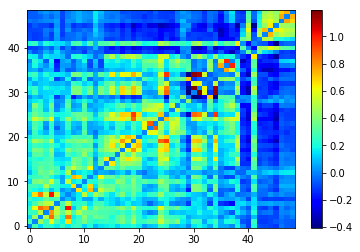

In [133]:
plt.imshow(nFC[:,:,:,70].mean(axis=0),aspect='auto',cmap='jet',origin='lower')
plt.colorbar()

In [160]:
delta = 15
nFC = np.zeros([ses.data.shape[0], ses.readinfo['pairs'].shape[0], int(np.ceil(ses.data.shape[-1]/delta)) ])
for i in tqdm( range(ses.data.shape[0]) ):
    for p in range( ses.readinfo['pairs'].shape[0] ):
        nFC[i,p,:] = data[i,ses.readinfo['pairs'][p,0],::delta] * data[i,ses.readinfo['pairs'][p,1],::delta]

100%|██████████| 540/540 [00:03<00:00, 150.39it/s]


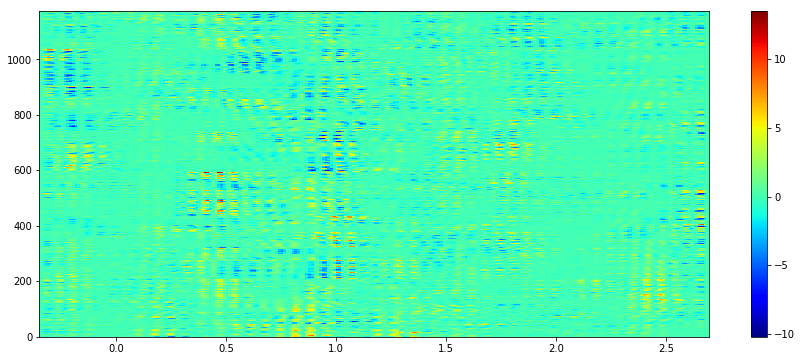

In [124]:
plt.figure(figsize=(15,6))
plt.imshow(nFC[10,:,:], aspect='auto', cmap='jet', origin='lower',
           extent=[tarray[0],tarray[-1],0,1176])
plt.colorbar()

In [149]:
nFCb = nFC>3

In [150]:
nFCb.shape

(540, 49, 49, 244)

In [151]:
d_m = nFCb.sum(axis=2).sum(axis=1).mean(axis=0)

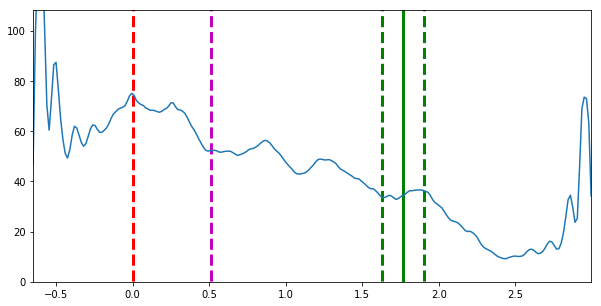

In [154]:
plt.figure(figsize=(10,5))
plt.plot(ses.readinfo['tarray'][::15], smooth(d_m, 5) )
plt.xlim([ses.readinfo['tarray'][::15][0], ses.readinfo['tarray'][::15][-1]])
plt.ylim([d_m.min(), d_m.max()-150])
plt.vlines(0, d_m.min()-6, d_m.max()+6, linestyle='--', linewidth = 3, color = 'r')
plt.vlines((ses.readinfo['t_cue_off']-ses.readinfo['t_cue_on']).mean()/1000, 
               d_m.min()-6, d_m.max()+6, linestyle='--', linewidth = 3, color = 'm')
plt.vlines((ses.readinfo['t_match_on']-ses.readinfo['t_cue_on']).mean()/1000, 
                   d_m.min()-6, d_m.max()+6, linestyle='-', linewidth = 3, color = 'g')
plt.vlines((ses.readinfo['t_match_on']-ses.readinfo['t_cue_on']).mean()/1000-(ses.readinfo['t_match_on']-ses.readinfo['t_cue_on']).std()/1000, 
                   d_m.min()-6, d_m.max()+6, linestyle='--', linewidth = 3, color = 'g')
plt.vlines((ses.readinfo['t_match_on']-ses.readinfo['t_cue_on']).mean()/1000+(ses.readinfo['t_match_on']-ses.readinfo['t_cue_on']).std()/1000, 
                   d_m.min()-6, d_m.max()+6, linestyle='--', linewidth = 3, color = 'g')

In [161]:
rates = nFC.sum(axis=1)

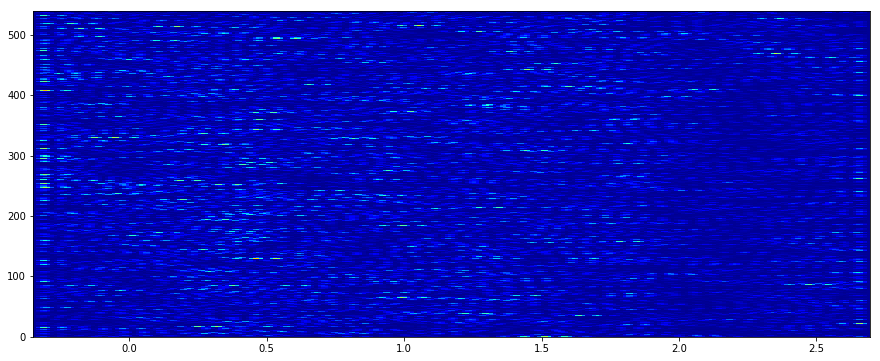

In [163]:
plt.figure(figsize=(15,6))
plt.imshow(rates,aspect='auto',cmap='jet',origin='lower', extent=[tarray[0],tarray[-1],0,540])

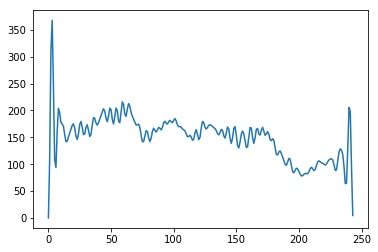

In [165]:
plt.plot(rates.mean(axis=0))

In [159]:
nFC.shape

(540, 49, 49, 244)

In [106]:
from MulticoreTSNE    import MulticoreTSNE as TSNE

In [113]:
aux = nFC.swapaxes(0,1).reshape(1176,540*244)

In [114]:
tsne = TSNE(n_jobs=40)
Y = tsne.fit_transform(aux[:,:40*244].T)

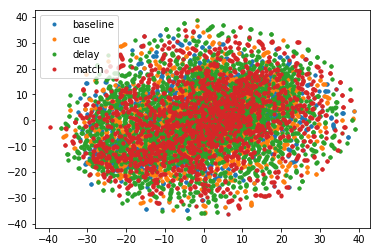

In [115]:
for i in range(len(stages)):
    plt.plot(Y[t_mask[i][:40*244],0], Y[t_mask[i][:40*244],1], '.', label = stages[i])
plt.legend()